# Seattle Crime Analysis

## We have crime incident data of Seattle for the summer of 2014.Looking into the crime data , we are trying to find answers for the following questions...
* What periods of the day have higher crime rates?
* Is the trend different during weekday or weekend?
* Do certain crime occur during certain periods of the day? etc
  
  

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set();
import warnings
warnings.filterwarnings('ignore')

## Data Preparation
Dataset given includes crime incident report for the summer months of the 2014 in Seattle.One of the key data we are considering is the "Date Reported" column.Using that data we are creating additonal derived features like the DayoftheWeek,if it a Weekday or Weekend,hour of the day etc.For the purpose of the analysis, we are also creating 5 additonal categories and mapping various crimes to each of these categories.Further analysis will be done ased on all these new features.

In [32]:
seattleData = pd.read_csv("seattle_incidents_summer_2014.csv")
seattleData.shape
ind = pd.DatetimeIndex(seattleData['Date Reported'])
seattleData['Dayofweek'] = ind.dayofweek
seattleData['DOW'] = ind.strftime('%a')
seattleData['Weekend'] = (ind.dayofweek>4)
seattleData['date'] = ind.date.astype('datetime64')
seattleData['hour'] = ind.hour



In [33]:
#Logical way to create new crime_category based on the data

MajorTheft = ('BURGLARY', 'EMBEZZLE','PROPERTY DAMAGE','LOST PROPERTY','BURGLARY-SECURE PARKING-RES','STOLEN PROPERTY',
              'OTHER PROPERTY','SHOPLIFTING','ROBBERY' )
               
MinorTheft = ('MAIL THEFT','BIKE THEFT','TRESPASS','THEFT OF SERVICES','PURSE SNATCH','PICKPOCKET')


AutoTheft = ('CAR PROWL','VEHICLE THEFT')

MajorOffense = ('LIQUOR VIOLATION','Assault','THREATS','NARCOTICS','ASSAULT','WARRANT ARREST',
                'PROSTITUTION','HOMICIDE','WEAPON','DUI','ESCAPE')

MinorOffense = ('FRAUD','FORGERY','COUNTERFEIT','DISPUTE','ELUDING'
               'INJURY','DISTURBANCE','VIOLATION OF COURT ORDER','TRAFFIC','ILLEGAL DUMPING',
                'BIAS INCIDENT','OBSTRUCT','RECKLESS BURNING','FALSE REPORT','ANIMAL COMPLAINT', 
                'PORNOGRAPHY','FIREWORK','[INC - CASE DC USE ONLY]', 'PUBLIC NUISANCE','DISORDERLY CONDUCT','RECOVERED PROPERTY')

seattleData.ix[seattleData["Summarized Offense Description"].isin(MajorTheft),"crime_category"] = "Major Theft"
seattleData.ix[seattleData["Summarized Offense Description"].isin(MinorTheft),"crime_category"] = "Minor Theft"
seattleData.ix[seattleData["Summarized Offense Description"].isin(AutoTheft),"crime_category"] = "Auto Theft"
seattleData.ix[seattleData["Summarized Offense Description"].isin(MajorOffense),"crime_category"] = "Major Offense"
seattleData.ix[seattleData["Summarized Offense Description"].isin(MinorOffense),"crime_category"] = "Minor Offense"



## Analysis 1: Is the crime happening during specific time of the day?Also, is there any difference in crime incidents between Weekday and Weekend?


### Let's plot the total number of crime incidents based on different hour of the day

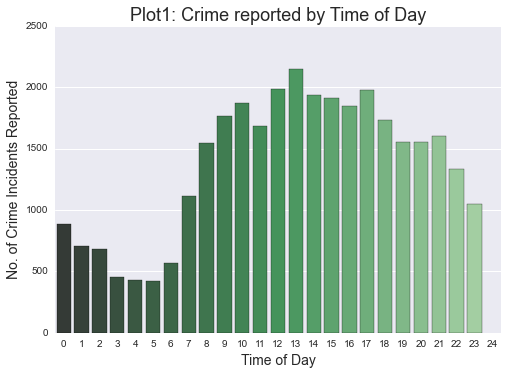

In [35]:
sns.countplot('hour',data=seattleData,order=range(25),palette="Greens_d")
plt.xlabel("Time of Day", fontsize=14)
plt.ylabel("No. of Crime Incidents Reported", fontsize=14)
plt.title("Plot1: Crime reported by Time of Day",fontsize=18)


In plot 1,we are looking at total crimes reported at each hour of the day. Following are 2 findings from the above plot.

* Time period between 9:00AM to 6:00PM record the highest crime rate.  
* Late evening crime rate is  higher than early morning crimes.                             

## Now, let's plot the total number of crime incidents per crime category based on different hour of the day

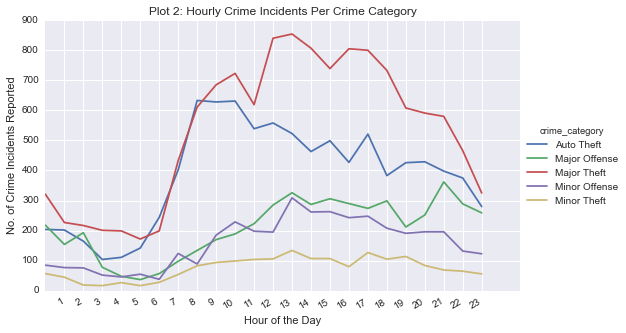

In [36]:
crimeCategorygroup = seattleData.groupby(["hour","crime_category"])
crimeCategorygroup = crimeCategorygroup.size().reset_index()
crimeCategorygroup.columns = ['hour','crime_category','count']

g = sns.FacetGrid(crimeCategorygroup, hue='crime_category', size=5, aspect=1.5)
g.map(plt.plot, 'hour', 'count').add_legend()
g.ax.set(xlabel='Hour of the Day',
         xticks = np.arange(1,24,1),
         ylabel='No. of Crime Incidents Reported',
         title='Plot 2: Hourly Crime Incidents Per Crime Category')
g.fig.autofmt_xdate()

In plot 2, we are looking at total crime incidents in each of the crime category at each hour of the day. Following are the findings
* Major Theft - For this category, crime is high between time period 9:00AM to 7:00PM
* Auto Theft - For this category,crime is at its peak at 8:00AM
* Major Offense - For this category,crime is high in the afternoon onwards and peak at 9:00PM

## Let's try to dive deeper into two of the crime categories.For each of these categories, let's plot the total number of crime incidents based on different hour of the day

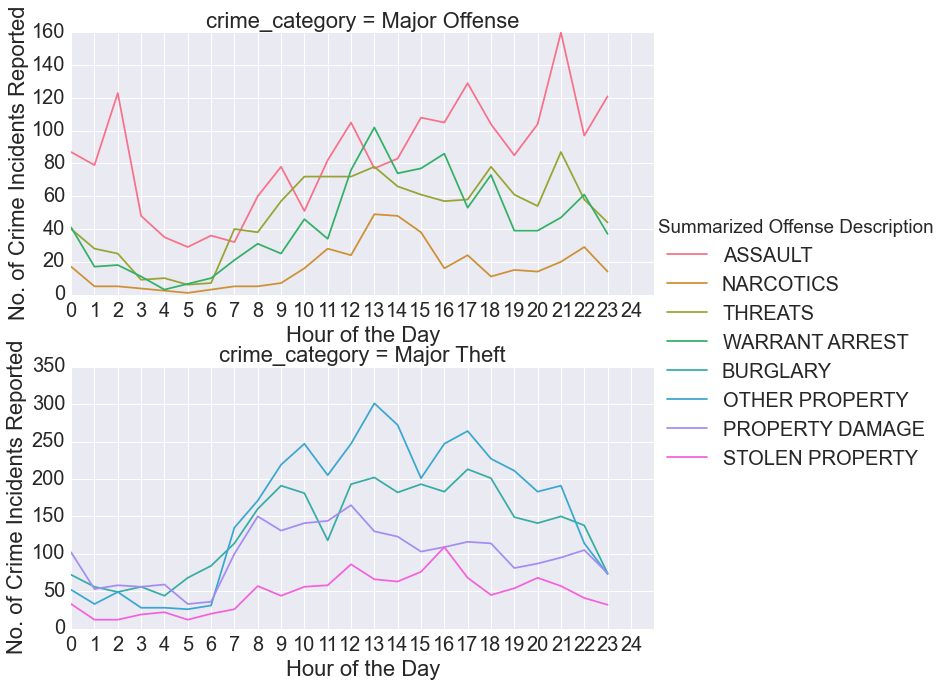

In [30]:
crimeCategorygroup = seattleData.groupby(["hour","crime_category","Summarized Offense Description"])

crimeCategorygroup = crimeCategorygroup.size().reset_index()

crimeCategorygroup.columns = ['hour','crime_category','Summarized Offense Description','count']


##Logic to pick the top n records from each of the groups based on the count.                         
select_number = pd.DataFrame({'number_to_select': {'Major Theft': 5, 'Minor Theft': 5, 
                                                   'Major Offense': 5,'Minor Offense': 5,
                                                    'Auto Theft' : 2}})

CCG =  crimeCategorygroup.groupby(["crime_category","Summarized Offense Description"]).sum().reset_index()
CCG = CCG[CCG["crime_category"].isin(["Major Theft", "Major Offense"])]
CCG = CCG.groupby(["crime_category"]).apply(lambda dfg: (dfg.nlargest(4, "count"))).reset_index(drop=True)

crimeCategorygroup= crimeCategorygroup[crimeCategorygroup["Summarized Offense Description"].isin(CCG["Summarized Offense Description"])] 

#with sns.plotting_context(font_scale=0):
g = sns.FacetGrid(crimeCategorygroup, row="crime_category",row_order =["Major Offense","Major Theft"],
                      hue="Summarized Offense Description", size=5, aspect=2,sharey=False,sharex=False) 
g.map(plt.plot, 'hour', 'count').add_legend()

g.set(xlabel='Hour of the Day',
      xticks = np.arange(0,25,1),
      ylabel='No. of Crime Incidents Reported')



                                      Plot 3

In plot 3, we are only analying crime data of 2 categories Major Theft and Major Offense.Following are the findings
* Assault - High during early morning and late evening
* Burglary - High during day time 

## Let's try to view this data from another angle this time i.e crime in each of the district. Does the crime incidents vary in each of these districts. Let's plot the crime incidents in each district based on different hour of the day

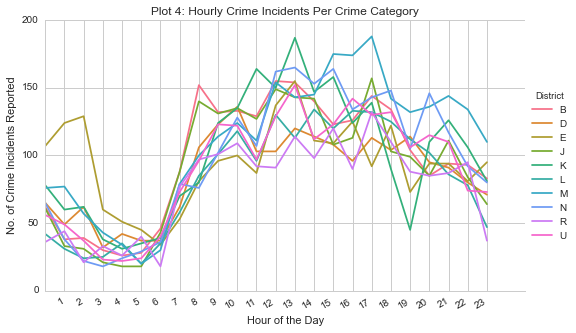

In [37]:
sns.set(style="whitegrid", color_codes=True)
districtGroup = seattleData.groupby('District/Sector')
districtGroup = districtGroup.size().sort_values( ascending=False).head(10)
subDataDistrict = seattleData[seattleData['District/Sector'].isin( districtGroup.index)]

subDataDistrictGroup = subDataDistrict.groupby(["hour","District/Sector"])
subDataDistrictGroup = subDataDistrictGroup.size().reset_index()
subDataDistrictGroup.columns = ['hour','District','count']
g = sns.FacetGrid(subDataDistrictGroup, hue='District', size=5, aspect=1.5)
g.map(plt.plot, 'hour', 'count').add_legend()
g.ax.set(xlabel='Hour of the Day',
         xticks = np.arange(1,24,1),
         ylabel='No. of Crime Incidents Reported',
         title='Plot 4: Hourly Crime Incidents Per Crime Category')
g.fig.autofmt_xdate()

## Result Analysis 1: 
Overall crime data shows that 9:00AM to 6:00PM has higher crime rates.Late evening have more crime than early morning.
Although this is a trend in general,there are some exceptions to this.
Auto Theft is high in the morning at 8:00AM.
Assault is more likely to happen during early morning and late evening
In most districts, crime incidents are at peak during days than at night. District K and M have higher crime incidents during lates evening(9:00PM - 10:00PM)
        

##  Analysis 2: In Seattle, do certain days of the week have more propensity for crime incidents? 
Let's zoom in deeper on each day to see if there is any day with higher crime rate.Let's plot the total crime incidents for each day of the week 

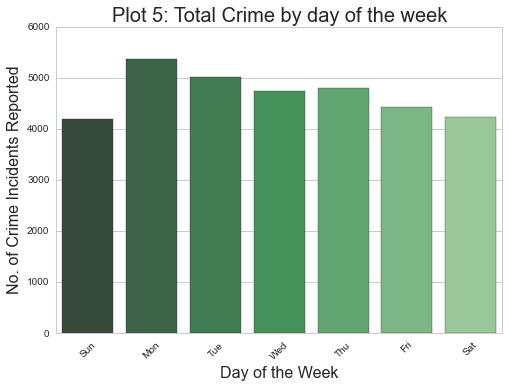

In [47]:
#Plot the crime count based on day of the week across the month of June,July,August 
#sns.set(style="whitegrid")
sns.countplot(x="DOW",data=seattleData,palette="Greens_d" ,order=('Sun','Mon','Tue','Wed','Thu','Fri','Sat'));
plt.xticks(rotation=45)
plt.xlabel("Day of the Week", fontsize=16)
plt.ylabel("No. of Crime Incidents Reported", fontsize=16)
plt.title("Plot 5: Total Crime by day of the week",fontsize=20)


In the above plot, we are plotting total crimes during each day of the week.

By looking at the plot, we see that crime is generally higher during weekdays(especially from Monday to Thursday). Monday tops the chart for crime incidents.

## To go further with the analysis, we should pick the top crime categories and understand if certain crime occur during certain days of the week. 

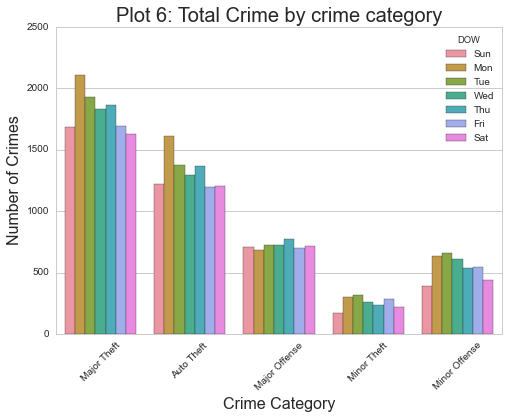

In [48]:
sns.countplot(x="crime_category",data=seattleData,hue="DOW" ,
              order=("Major Theft","Auto Theft","Major Offense","Minor Theft","Minor Offense"),
              hue_order=('Sun','Mon','Tue','Wed','Thu','Fri','Sat'));
plt.xticks(rotation=45)
plt.xlabel("Crime Category", fontsize=16)
plt.ylabel("Number of Crimes", fontsize=16)
plt.title("Plot 6: Total Crime by crime category",fontsize=20)


In the above plot, we look at all the crime categories across different days of the week. 
Following are the findings from above analysis,
* Crime rates are higher in weekdays than in weekends.
* Crime rate is higher on Monday. Especially for Major Theft and Auto Theft.
* Crime rate in the Major Offense category is same across all days of the week.


## Let's pick the top 10 crime incidents based on its total number of occurance. For each of these incidents let's plot the crime incidents for each day of the week

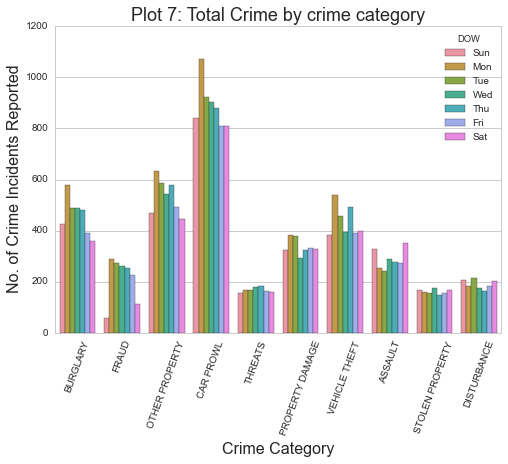

In [49]:
##Find the top crime categories 
offenseGroupdf = seattleData.groupby('Summarized Offense Description')
offenseGroup = offenseGroupdf.size().sort_values( ascending=False).head(10)
subDataOffense = seattleData[seattleData['Summarized Offense Description'].isin( offenseGroup.index)]
sns.countplot(x="Summarized Offense Description",hue="DOW", hue_order=('Sun','Mon','Tue','Wed','Thu','Fri','Sat'),
              data=subDataOffense);
plt.xticks(rotation=70)
plt.xlabel("Crime Category", fontsize=16)
plt.ylabel("No. of Crime Incidents Reported", fontsize=16)
plt.title("Plot 7: Total Crime by crime category",fontsize=18)


In the above plot,we are analyzing top 10 crime incidents and seeing if certain incidents occur more during certain days of the week.
Following are the findings
* Fraud,Burglary is really low during weekends
* Assault is higher during weekends than in weekdays

## Just how we performed analysis for each district in Analsyis 1, here we will do a similar analysis. We will pick districts with high crime rate and analyze the data across different days of the week.

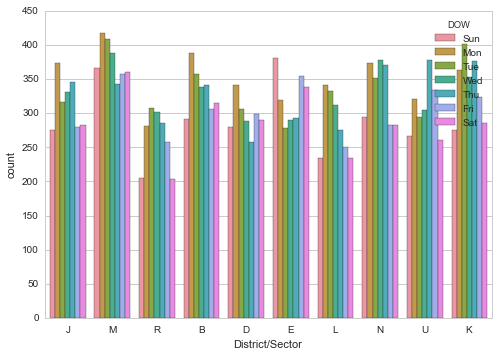

In [464]:
#Plot the top  district based in the crime rate
sns.set(style="whitegrid", color_codes=True)
sns.countplot(x="District/Sector", data=subDataDistrict, hue='DOW',hue_order=('Sun','Mon','Tue','Wed','Thu','Fri','Sat'));


### In the above plot, we are looking at districts with highest crime rate. Following are the findings from this plot
* Other than sector E, all the other sectors has more crime during weekdays than in weekend. Only in sector E, crime rate is relatively lower during Monday-Thursday than Friday-Sunday.

## Result Analysis 2:
Overall crime data shows that crime incidents reported are higher on Mondays.Weekdays have higher crime incidents than weekends.
Although this is a trend in general,there are some exceptions to this.
Assault is higher during weekends than in weekdays
District E, has higher crime incidents during weekends than in weekdays.



# Conclusion

With the current level of data analysis, we have some basic findings as summarized below

1. Crime incidents are higher during the time-period of 8:00am - 8:00pm.
2. Surge in crime incidents at 8:00am. Caveat: This surge could be due to people reporting in the morning, but the actual crime could have happened during the night before
3. District E has more crime during weekends than weekdays.
4. Assault related crimes are higher during weekend



